# Comparison of Sampling Techniques

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from fairpair import *

In [2]:
# Generate a new Graph to test sampling
G = FairPairGraph()
G.generate_groups(400, 200) # same size groups
G.assign_skills(loc=0, scale=0.86142674) # general skill distribution
G.assign_bias(nodes=G.unpriv_nodes, loc=-1.43574282, scale=0.43071336) # add bias to unprivileged group

/home/georg/anaconda3/envs/torchsort/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/georg/anaconda3/envs/torchsort/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/georg/anaconda3/envs/torchsort/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/georg/anaconda3/envs/torchsort/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

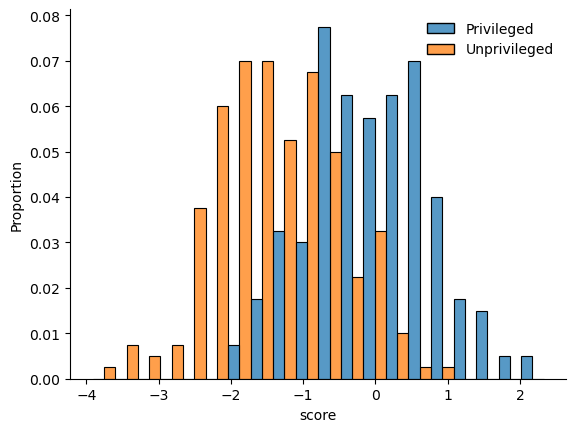

In [3]:
# Distribution of Average Perceived Score among the nodes we created
df = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
ax = sns.histplot(data=df, x='score', hue='unpriv', stat='proportion', bins=20, multiple='dodge')
ax.legend(ax.get_legend().legend_handles, ['Privileged', 'Unprivileged'], title=None, frameon=False)
sns.despine()

## Random Sampling

In [4]:
# Comparisons and Success Rates by group for RandomSampling after 100 iterations
F = G.copy()
sampling = RandomSampling(F, log_comparisons=True, log_success=True, warn=False)
sampling.apply(iter=100, k=1)

comparisons = F.comparisons
print('unprivileged group\'s comparisons:', round(sum([compared for node, compared in comparisons if node in F.unpriv_nodes]), 2))
print('privileged group\'s comparisons:', round(sum([compared for node, compared in comparisons if node in F.priv_nodes]), 2))

success_rates = F.success_rates
print('unprivileged group\'s success rate:', round(np.mean([rate for node, rate in success_rates if node in F.unpriv_nodes]), 2))
print('privileged group\'s success rate:', round(np.mean([rate for node, rate in success_rates if node in F.priv_nodes]), 2))

unprivileged group's comparisons: 3965
privileged group's comparisons: 4035
unprivileged group's success rate: 0.38
privileged group's success rate: 0.62


In [5]:
# Run 10_000 iterations to create a heatmap and histogram of edge weights
F = G.copy()
sampling = RankSampling(F, warn=False)
ranker = RankRecovery(F)
ranking = None
for i in range(100):
    sampling.apply(iter=100, k=1, ranking=ranking)
    if nx.is_strongly_connected(F):
        ranking, other_nodes = ranker.apply(rank_using=rankCentrality)

nodes = list(F.nodes(data='score'))
nodes = [node[0] for node in sorted(nodes, key=lambda x:x[1])]
A = nx.linalg.graphmatrix.adjacency_matrix(F, weight='weight', nodelist=nodes)
A = A.todense()
mask = nx.linalg.graphmatrix.adjacency_matrix(F, weight=None, nodelist=nodes) # get the non-existing edges
mask = mask.todense()
f = lambda x: x==0
mask = f(mask)

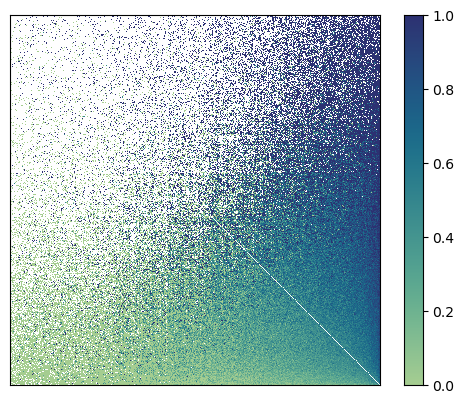

In [6]:
sns.heatmap(A, mask=mask, cmap='crest', xticklabels=False, yticklabels=False, cbar=True, square=True)
sns.despine(top=False, right=False)

/home/georg/anaconda3/envs/torchsort/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/georg/anaconda3/envs/torchsort/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


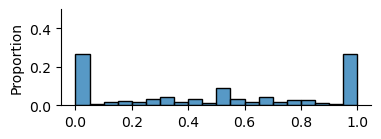

In [7]:
A_masked = np.ma.array(data=A, mask=mask)
plt.figure(figsize=(4,1.25))
ax = sns.histplot(data=A_masked.flatten(), stat='proportion', bins=20)
ax.set(ylim=(0,0.5))
sns.despine()

## Oversampling

In [8]:
# Comparisons and Success Rates by group for Oversampling after 100 iterations
F = G.copy()
sampling = Oversampling(F, log_comparisons=True, log_success=True, warn=False)
sampling.apply(iter=100, k=1, p=0.75) # p specifies the amount of oversampling to apply

comparisons = F.comparisons
print('unprivileged group\'s comparisons:', round(sum([compared for node, compared in comparisons if node in F.unpriv_nodes]), 2))
print('privileged group\'s comparisons:', round(sum([compared for node, compared in comparisons if node in F.priv_nodes]), 2))

success_rates = F.success_rates
print('unprivileged group\'s success rate:', round(np.mean([rate for node, rate in success_rates if node in F.unpriv_nodes]), 2))
print('privileged group\'s success rate:', round(np.mean([rate for node, rate in success_rates if node in F.priv_nodes]), 2))

unprivileged group's comparisons: 6000
privileged group's comparisons: 2000
unprivileged group's success rate: 0.44
privileged group's success rate: 0.67


## Rank-Based Sampling

In [9]:
# Comparisons and Success Rates by group for Rank-Based Sampling after 100 iterations
F = G.copy()
sampling = RankSampling(F, log_comparisons=True, log_success=True, warn=False)
ranker = RankRecovery(F)  # Rank-Based Sampling requires intermediate recovery of rankings
ranking = None
for i in range(100):
    sampling.apply(iter=1, k=1, ranking=ranking)
    if nx.is_weakly_connected(F):
        ranking, other_nodes = ranker.apply(rank_using=rankCentrality)

comparisons = F.comparisons
print('unprivileged group\'s comparisons:', round(sum([compared for node, compared in comparisons if node in F.unpriv_nodes]), 2))
print('privileged group\'s comparisons:', round(sum([compared for node, compared in comparisons if node in F.priv_nodes]), 2))

success_rates = F.success_rates
print('unprivileged group\'s success rate:', round(np.mean([rate for node, rate in success_rates if node in F.unpriv_nodes]), 2))
print('privileged group\'s success rate:', round(np.mean([rate for node, rate in success_rates if node in F.priv_nodes]), 2))

unprivileged group's comparisons: 2599
privileged group's comparisons: 5401
unprivileged group's success rate: 0.28
privileged group's success rate: 0.47
